# CNN

## 1. Imports

### 1.1 Setup for Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
ls

 CNN_Final.ipynb                            RGB/
'Correct_CNN_EarlyFusion_Final (1).ipynb'   RgbAug/
 Correct_CNN_RGB_Final.ipynb                Thermal/
 Correct_CNN_THERMAL_Final.ipynb            ThermalAug/
 Norm_Copy_of_CNN_RGB_Final.ipynb           trainingResults/


### 1.2 Install Depedencies

In [ ]:
#install dependencies
# !pip install -r requirements.txt

In [4]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import time
from datetime import datetime

### 1.2 Global Variables

In [5]:
EPOCHS = 30
CLASSES = 7
BATCH_SIZE = 64
NUM_WORKERS = 12 # change based on specification of computer
LEARNING_RATE = 0.001

## 2. Load Data and Split

In [6]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [18]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (uaing raw and augmented data together)

#change this to test either thermal or rgb
modalDir = thermalDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 20695
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: Thermal/T_Angry_10_KTFE.jpg
Label: Angry



### 2.2 Multi Modality

In [ ]:
def loadDataMultiModality(rgbDir,thermalDir):
    '''
    Loads and processes data from both RGB and Thermal modalities.
    Args:
        rgbDir (list): List containing two directory paths for RGB images - first for raw images, second for augmented images.
        thermalDir (list): List containing two directory paths for Thermal images - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of tuples, each containing a pair of (RGB image path, Thermal image path).
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''


    #get list of files in the directory and combine them
    rgbFiles = []
    thermalFiles = []
    for data in rgbDir:
        rgbFiles.extend(glob.glob(os.path.join(data, "*")))
    for data in thermalDir:
        thermalFiles.extend(glob.glob(os.path.join(data, "*")))

    #pairs thermal and rgb files together
    pairedFiles = list(zip(rgbFiles, thermalFiles))
    print(f"Total pairs: {len(pairedFiles)}")

    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in thermalFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For multi modality testing (using raw and augmented data together)

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataMultiModality(rgbDir,thermalDir)

### 2.3 Split Data
- 80:20

In [19]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 16556
Test size: 4139


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

In [21]:
class SingleModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        imagePath = self.pairedFiles[idx]
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


train_dataset = SingleModalImageDataset(X_train, y_train, transform=transform)
test_dataset = SingleModalImageDataset(X_test, y_test, transform=transform)

### 3.2 Multi Modality

In [ ]:
class MultiModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        rgbPath,thermalPath  = self.pairedFiles[idx]
        rgb = Image.open(rgbPath).convert('RGB')
        thermal = Image.open(thermalPath).convert('RGB') #try L greyscale

        if self.transform:
            rgb = self.transform(rgb)
            thermal = self.transform(thermal)

        label = self.labels[idx]
        return (rgb,thermal),label

train_dataset = MultiModalImageDataset(X_train, y_train, transform=transform)
test_dataset = MultiModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. ShuffleNet V.2

### 4.1 Single Modality

In [23]:
import torch.optim as optim

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize model
model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, CLASSES)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# To collect metrics
trainLosses = []
trainAccuracies = []
testAccuracies = []   # use test_loader as validation here

print("Starting training...")
training_start_time = time.time()
print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    # training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item() * x.size(0)

        # Track accuracy
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    trainLoss = running_loss / len(train_loader.dataset)
    trainAcc = correct / total

    # validation
    model.eval()
    test_correct, test_total = 0, 0
    predictionsArr, targetsArr = [], []
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch+1} Testing"):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = outputs.max(1)

            test_correct += (predicted == y).sum().item()
            test_total += y.size(0)

            # save predictions for last epoch only
            if epoch == EPOCHS - 1:
                predictionsArr.extend(predicted.cpu().numpy())
                targetsArr.extend(y.cpu().numpy())

    testAcc = test_correct / test_total

    trainLosses.append(trainLoss)
    trainAccuracies.append(trainAcc)
    testAccuracies.append(testAcc)

    epoch_time = (time.time() - epoch_start_time) / 60
    print(f"Epoch {epoch+1}: "
          f"Train Loss = {trainLoss:.4f}, Train Acc = {trainAcc:.4f}, "
          f"Test Acc = {testAcc:.4f}, Time = {epoch_time:.2f} min")

total_time = (time.time() - training_start_time) / 60
print("\nTraining completed.")
print(f"Total Training Time: {total_time:.2f} min")
print(f"Best Training Accuracy: {max(trainAccuracies):.4f}")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")

Starting training...
Training started at: 2025-09-10 20:57:55


Epoch 1 Testing: 100%|██████████| 65/65 [01:18<00:00,  1.21s/it]


Epoch 1: Train Loss = 0.8629, Train Acc = 0.6482, Test Acc = 0.8128, Time = 7.32 min


Epoch 2 Testing: 100%|██████████| 65/65 [00:18<00:00,  3.49it/s]


Epoch 2: Train Loss = 0.2985, Train Acc = 0.8867, Test Acc = 0.9077, Time = 1.50 min


Epoch 3 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.75it/s]


Epoch 3: Train Loss = 0.1595, Train Acc = 0.9417, Test Acc = 0.9311, Time = 1.48 min


Epoch 4 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]


Epoch 4: Train Loss = 0.1121, Train Acc = 0.9601, Test Acc = 0.9316, Time = 1.48 min


Epoch 5 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]


Epoch 5: Train Loss = 0.0885, Train Acc = 0.9685, Test Acc = 0.9432, Time = 1.48 min


Epoch 6 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.82it/s]


Epoch 6: Train Loss = 0.0636, Train Acc = 0.9790, Test Acc = 0.9621, Time = 1.42 min


Epoch 7 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch 7: Train Loss = 0.0622, Train Acc = 0.9804, Test Acc = 0.9541, Time = 1.47 min


Epoch 8 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.84it/s]


Epoch 8: Train Loss = 0.0493, Train Acc = 0.9839, Test Acc = 0.9613, Time = 1.44 min


Epoch 9 Testing: 100%|██████████| 65/65 [00:18<00:00,  3.42it/s]


Epoch 9: Train Loss = 0.0521, Train Acc = 0.9841, Test Acc = 0.9304, Time = 1.48 min


Epoch 10 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.89it/s]


Epoch 10: Train Loss = 0.0331, Train Acc = 0.9885, Test Acc = 0.9700, Time = 1.44 min


Epoch 11 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.73it/s]


Epoch 11: Train Loss = 0.0383, Train Acc = 0.9879, Test Acc = 0.9526, Time = 1.41 min


Epoch 12 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch 12: Train Loss = 0.0439, Train Acc = 0.9854, Test Acc = 0.9592, Time = 1.43 min


Epoch 13 Testing: 100%|██████████| 65/65 [00:16<00:00,  4.05it/s]


Epoch 13: Train Loss = 0.0279, Train Acc = 0.9912, Test Acc = 0.9645, Time = 1.42 min


Epoch 14 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.97it/s]


Epoch 14: Train Loss = 0.0354, Train Acc = 0.9886, Test Acc = 0.9681, Time = 1.39 min


Epoch 15 Testing: 100%|██████████| 65/65 [00:16<00:00,  4.06it/s]


Epoch 15: Train Loss = 0.0356, Train Acc = 0.9890, Test Acc = 0.9517, Time = 1.41 min


Epoch 16 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.93it/s]


Epoch 16: Train Loss = 0.0356, Train Acc = 0.9886, Test Acc = 0.9553, Time = 1.43 min


Epoch 17 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.64it/s]


Epoch 17: Train Loss = 0.0266, Train Acc = 0.9916, Test Acc = 0.9638, Time = 1.41 min


Epoch 18 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.67it/s]


Epoch 18: Train Loss = 0.0299, Train Acc = 0.9907, Test Acc = 0.9601, Time = 1.42 min


Epoch 19 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.96it/s]


Epoch 19: Train Loss = 0.0261, Train Acc = 0.9917, Test Acc = 0.9628, Time = 1.43 min


Epoch 20 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.97it/s]


Epoch 20: Train Loss = 0.0177, Train Acc = 0.9939, Test Acc = 0.9681, Time = 1.44 min


Epoch 21 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.87it/s]


Epoch 21: Train Loss = 0.0253, Train Acc = 0.9917, Test Acc = 0.9662, Time = 1.46 min


Epoch 22 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.73it/s]


Epoch 22: Train Loss = 0.0324, Train Acc = 0.9892, Test Acc = 0.9621, Time = 1.45 min


Epoch 23 Testing: 100%|██████████| 65/65 [00:15<00:00,  4.14it/s]


Epoch 23: Train Loss = 0.0318, Train Acc = 0.9895, Test Acc = 0.9720, Time = 1.40 min


Epoch 24 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.79it/s]


Epoch 24: Train Loss = 0.0185, Train Acc = 0.9950, Test Acc = 0.9744, Time = 1.38 min


Epoch 25 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.77it/s]


Epoch 25: Train Loss = 0.0165, Train Acc = 0.9946, Test Acc = 0.9650, Time = 1.46 min


Epoch 26 Testing: 100%|██████████| 65/65 [00:16<00:00,  3.91it/s]


Epoch 26: Train Loss = 0.0219, Train Acc = 0.9932, Test Acc = 0.9638, Time = 1.43 min


Epoch 27 Testing: 100%|██████████| 65/65 [00:18<00:00,  3.56it/s]


Epoch 27: Train Loss = 0.0324, Train Acc = 0.9892, Test Acc = 0.9642, Time = 1.40 min


Epoch 28 Testing: 100%|██████████| 65/65 [00:16<00:00,  4.01it/s]


Epoch 28: Train Loss = 0.0180, Train Acc = 0.9933, Test Acc = 0.9662, Time = 1.39 min


Epoch 29 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.69it/s]


Epoch 29: Train Loss = 0.0166, Train Acc = 0.9952, Test Acc = 0.9568, Time = 1.42 min


Epoch 30 Testing: 100%|██████████| 65/65 [00:17<00:00,  3.72it/s]

Epoch 30: Train Loss = 0.0342, Train Acc = 0.9891, Test Acc = 0.9560, Time = 1.44 min

Training completed.
Total Training Time: 48.93 min
Best Training Accuracy: 0.9952
Best Test Accuracy: 0.9744


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [24]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

# Save training loss, training accuracy, and validation accuracy to CSV
metrics = pd.DataFrame({
    'Epoch': range(1, len(trainLosses) + 1),
    'Training Loss': trainLosses,
    'Training Accuracy': trainAccuracies,
    'Validation Accuracy': testAccuracies
})

# Save based on modality used
if savingLabel == "RGB":
    metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
    metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
    metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)

### 5.2 Visualise Graphs

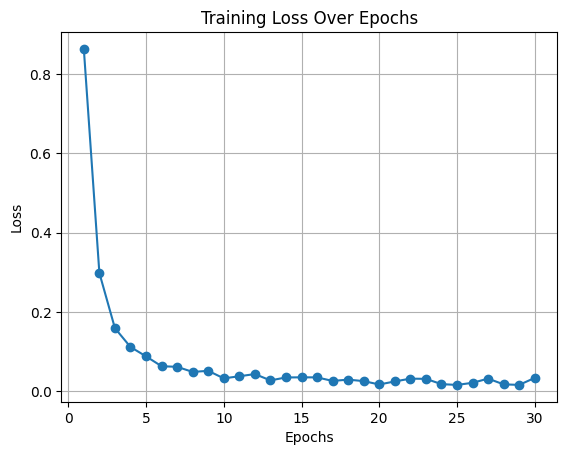

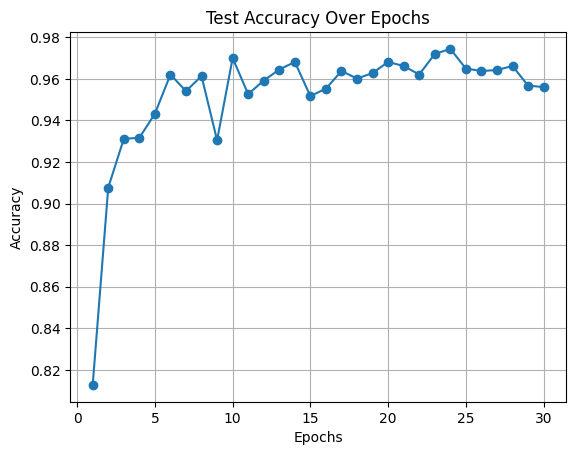

In [25]:
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "trainLoss_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "trainLoss_Thermal.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "testAccuracy_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "testAccuracy_Thermal.png"))
plt.show()

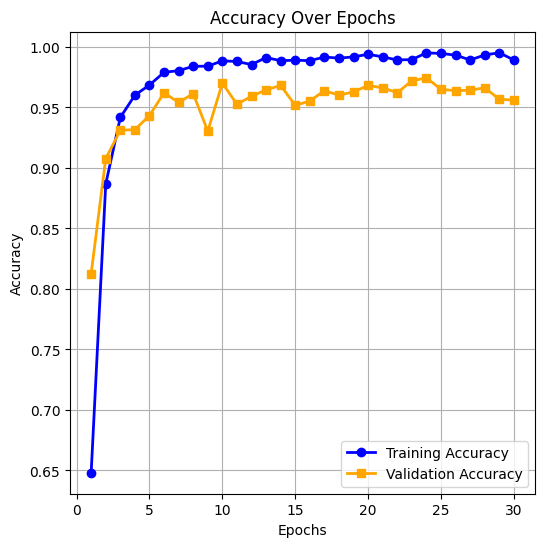

In [27]:
# training and validation accuracy plot
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(trainAccuracies) + 1), trainAccuracies,
         marker='o', color='blue', label='Training Accuracy', linewidth=2)
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies,
         marker='s', color='orange', label='Validation Accuracy', linewidth=2)

plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Save plot
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "accuracy_RGB.png"))
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "accuracy_Thermal.png"))
else:
    plt.savefig(os.path.join(saveResults, "accuracy_MultiModal.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

       Angry       0.90      0.98      0.94       780
     Disgust       0.96      0.90      0.93       221
        Fear       0.98      0.92      0.95       346
       Happy       0.96      0.96      0.96      1206
     Neutral       0.93      0.99      0.96       103
         Sad       0.99      0.99      0.99       883
   Surprised       0.95      0.91      0.93       600

    accuracy                           0.96      4139
   macro avg       0.95      0.95      0.95      4139
weighted avg       0.96      0.96      0.96      4139



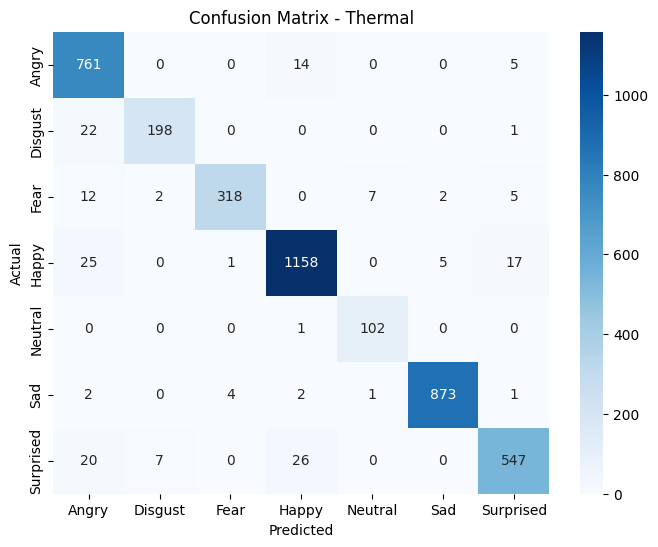

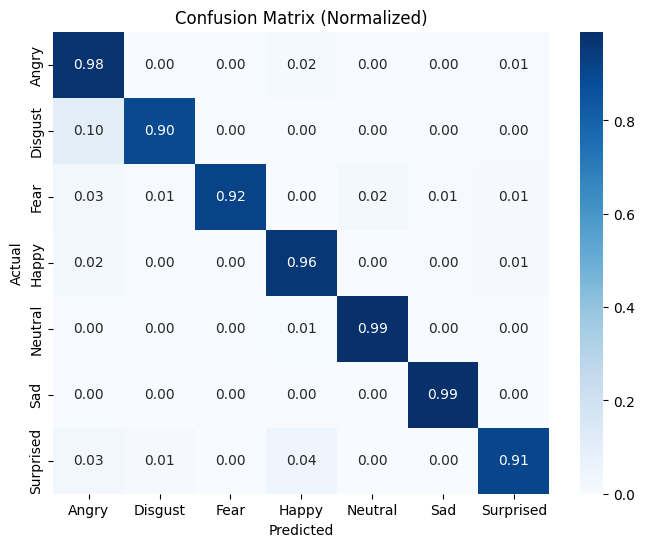

In [28]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)
report = classification_report(targetsArr, predictionsArr, target_names=classNames)

print("\nClassification Report:")
print(report)

# Save classification report
if savingLabel == "RGB":
    with open(os.path.join(saveResults, "classificationReport_RGB.txt"), "w") as f:
        f.write(report)
elif savingLabel == "Thermal":
    with open(os.path.join(saveResults, "classificationReport_Thermal.txt"), "w") as f:
        f.write(report)
else:
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            xticklabels=classNames,
            yticklabels=classNames,
            cmap="Blues")

plt.title(f"Confusion Matrix - {savingLabel}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save confusion matrix
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_RGB.png"), bbox_inches="tight")
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_Thermal.png"), bbox_inches="tight")
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"), bbox_inches="tight")

plt.show()


# normalized Confusion Matrix
conf_matrix_norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f",
            xticklabels=classNames, yticklabels=classNames, cmap="Blues")
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save figure based on modality
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_RGB.png"))
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_Thermal.png"))
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrixNormalized_MultiModal_EarlyFusion.png"))
plt.show()



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


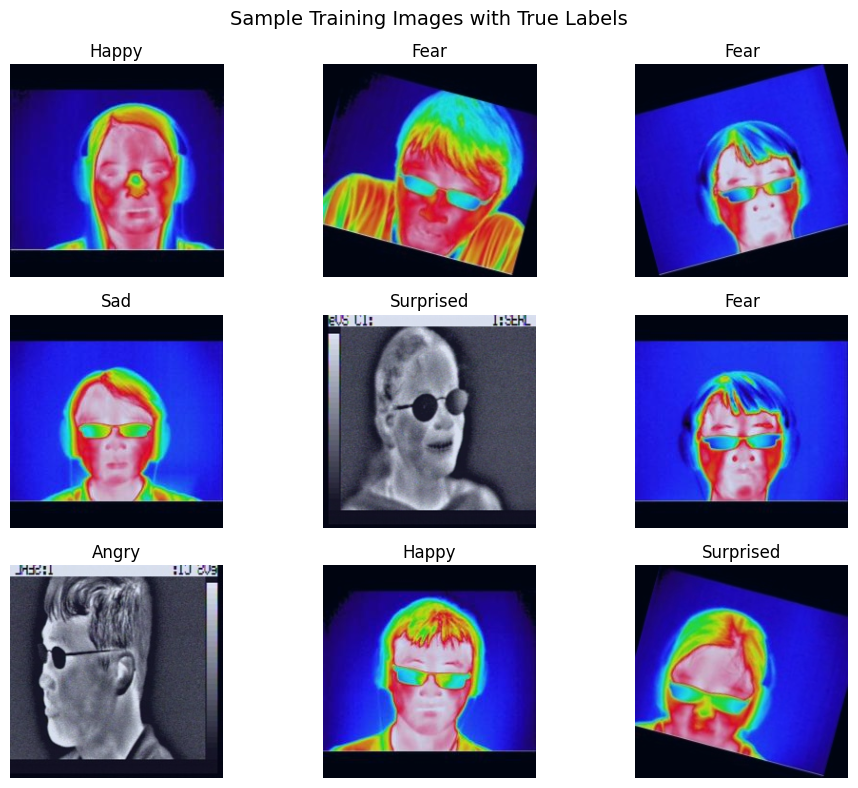

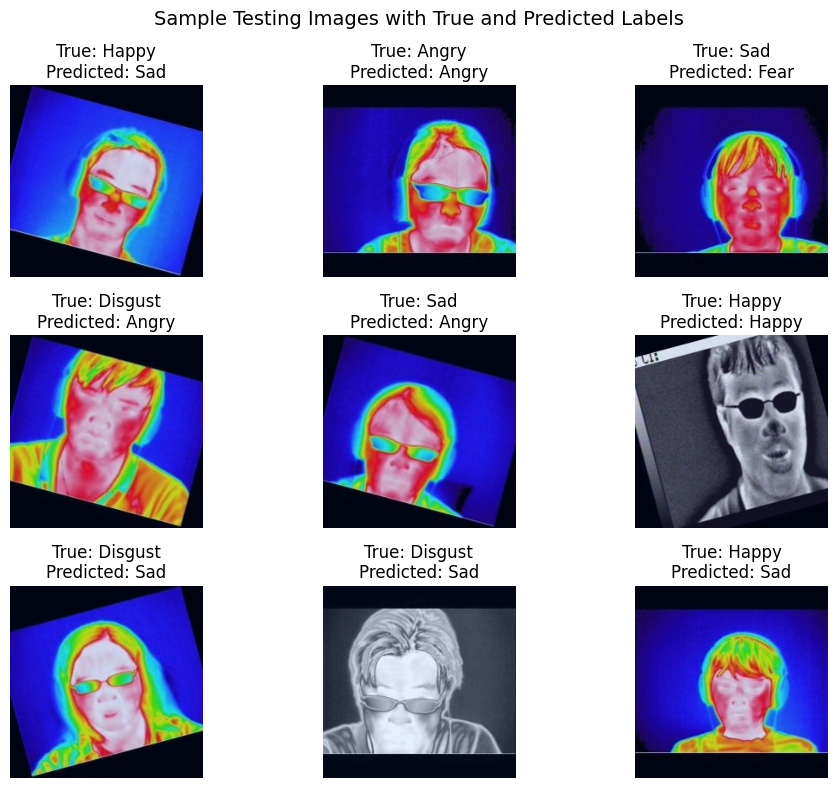

In [29]:
#visualising some images and their labels

#true images and labels
imagesPlot, labelsPlot = next(iter(train_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlot[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
    ax.set_title(classNames[labelsPlot[i]])
    ax.axis('off')
    plt.suptitle('Sample Training Images with True Labels',fontsize=14)
plt.tight_layout()


#predicted images and labels
imagesPlotPred, labelsPlotPred = next(iter(test_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlotPred[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))

    trueLabel = classNames[labelsPlotPred[i]]
    predictedLabel = classNames[predicted[i]]

    ax.set_title(f'True: {trueLabel}\nPredicted: {predictedLabel}')
    ax.axis("off")
    plt.suptitle('Sample Testing Images with True and Predicted Labels',fontsize=14)
plt.tight_layout()